In Wang et al. (2009) they estimate the divergence starting from the estimate
$$KL(p||q) \approx \frac{1}{n} \sum\limits_{i=1}^n \log \frac{\hat{p}(X_i)}{\hat{q}(X_i)}$$ 
They they estimate $\hat{p}(X_i)$ and $\hat{q}(X_i)$ using the $k$ Nearest Neighbor method to ultimately get
$$KL(p||q) \approx = \frac{d}{n} \sum\limits_{i=1}^n \log \frac{\nu_k(i)}{\rho_k(X_i)} + \log \frac{m}{n-1}$$
__However in our case, we don't need to estimate $\hat{q}(X_i)$ since $q$ in our case is just a multivariate Gaussian.__

In this notebook I will implement the new KL estimator and verify that it works for a handful of cases

In [1]:
import numpy as np
from scipy.special import gamma as Gamma
from scipy.special import gammaln as GammaLn
from numpy.random import multivariate_normal as mvn 
from scipy.stats import multivariate_normal as multinorm
#
from sklearn.neighbors import NearestNeighbors
# -- nonGaussLike -- 
from nongausslike import knn as kNN
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
def c_1(d): 
    return np.pi**(0.5 * float(d)) / Gamma(0.5*float(d)+1)

In [4]:
def hat_p(X, k=10): 
    n, d = X.shape # n and dimensions
    k, n, d = float(k), float(n), float(d)

    # kNN term
    NN_X = NearestNeighbors(n_neighbors=int(k)).fit(X)
    dNN_XX, _ = NN_X.kneighbors(X, n_neighbors=int(k)+1) # k+1 to exclude itself
    rho_k_i = dNN_XX[:,-1]
    
    return k/(n-1) * 1 / (c_1(d) * rho_k_i**d)

In [5]:
def KL_Xq(X, q, k=10): 
    ''' X is a matrix, k is float, q is a function 
    '''
    try: 
        n, d = X.shape
    except ValueError: 
        n, d = X.reshape(-1,1).shape

    p_Xi = hat_p(X, k=k)
    q_Xi = q(X)
    return np.sum(np.log(p_Xi) - np.log(q_Xi))/n

In [6]:
ns = np.array([1e2, 1e3, 2e3, 3e3, 4e3, 1e4])#, 1e5])
ns = ns.astype(int)

In [7]:
qX = lambda x: multinorm.pdf(x, mean=0., cov=1.)
kls = [] 
for n in ns: 
    Xn = np.random.normal(0., 1., size=int(n))#mvn([0.], [1.], size=int(n))
    kls.append(KL_Xq(Xn.reshape(-1,1), qX, k=50))

Text(0,0.5,'$KL(X_{1:n} \\sim N(0, 1) || N(0, 1))$')

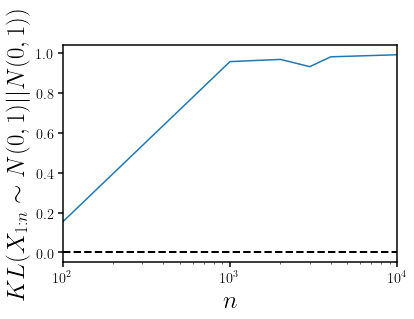

In [19]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, kls)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([ns[0], ns[-1]])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0., 0.], c='k', lw=2, ls='--')
sub.set_ylabel('$KL(X_{1:n} \sim N(0, 1) || N(0, 1))$', fontsize=25)

In [26]:
mu_p = np.array([0.1, 0.3, 0.6, 0.9])
mu_q = np.array([0., 0., 0., 0.])
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.5
            cov_q[i,j] = 0.1

In [34]:
qX = lambda x: multinorm.pdf(x, mean=mu_p, cov=cov_p)
kls = [] 
for n in ns: 
    Xn = mvn(mu_p, cov_p, size=int(n))
    kls.append(KL_Xq(Xn, qX, k=50))

Text(0,0.5,'$KL(X_{1:n} \\sim N(\\mu_p, C_p) || N(\\mu_q, C_q))$')

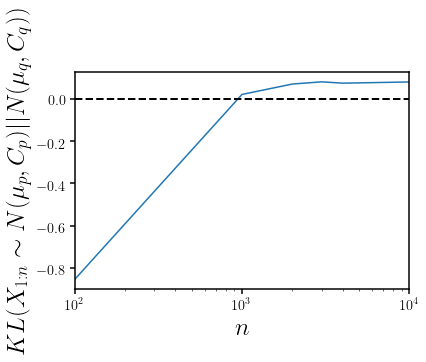

In [35]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, kls)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([ns[0], ns[-1]])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0., 0.], c='k', lw=2, ls='--')
sub.set_ylabel('$KL(X_{1:n} \sim N(\mu_p, C_p) || N(\mu_q, C_q))$', fontsize=25)

In [36]:
qX = lambda x: multinorm.pdf(x, mean=mu_q, cov=cov_q)
kls = [] 
for n in ns: 
    Xn = mvn(mu_p, cov_p, size=int(n))
    kls.append(KL_Xq(Xn, qX, k=50))

Text(0,0.5,'$KL(X_{1:n} \\sim N(\\mu_p, C_p) || N(\\mu_q, C_q))$')

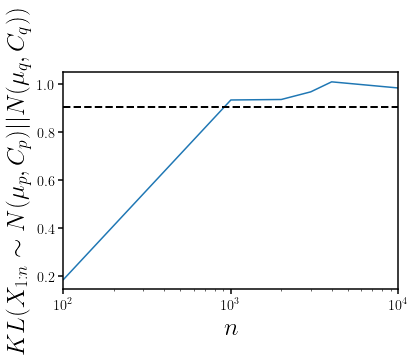

In [37]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, kls)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([ns[0], ns[-1]])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0.9009, 0.9009], c='k', lw=2, ls='--')
sub.set_ylabel('$KL(X_{1:n} \sim N(\mu_p, C_p) || N(\mu_q, C_q))$', fontsize=25)

In [38]:
mu_p = np.zeros(20)
mu_q = np.zeros(20)
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.2
            cov_q[i,j] = 0.2

In [39]:
qX = lambda x: multinorm.pdf(x, mean=mu_q, cov=cov_q)

(-5.0, 1)

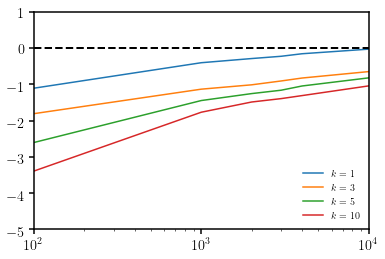

In [40]:
fig = plt.figure()
sub = fig.add_subplot(111)
for k in [1, 3, 5, 10]: 
    kls = [] 
    for n in ns: 
        Xn = mvn(mu_p, cov_p, size=int(n))
        kls.append(KL_Xq(Xn, qX, k=k))
    sub.plot(ns, kls, label=r'$k='+str(k)+'$')
sub.legend(loc='lower right')
sub.set_xlim([1e2, 1e4])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0., 0.], c='k', lw=2, ls='--')
sub.set_ylim([-5., 1])